In [45]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.mosaicplot import mosaic
sns.set(style="white", context="talk")

In [46]:
colours_cafe = np.array(['#6B3231', '#DB565D', '#FACCAD', '#FF8A40'])
colours_cafe = sns.set_palette(sns.color_palette(colours_cafe))

In [269]:
contra = pd.read_csv('../../1-data/contra.csv')
contra_train = pd.read_csv('../../1-data/train.csv')
contra_test = pd.read_csv('../../1-data/test.csv')

contra_untransf = pd.read_csv('../../1-data/contra-untransf.csv')
contra_train_untransf = pd.read_csv('../../1-data/train-untransf.csv')

# Subset verification.

The t-test below is verifying the representativeness of number of children within this subset of the full national survey. We are testing whether or not the mean "fertility rate" which is the number of children a woman has in her lifetime is truly 3.3 or not according to a Wilcoxon Signed-Rank test.

In [277]:
contra_untransf.shape

(1409, 18)

In [282]:
np.mean(contra_untransf['num_child']), np.std(contra_untransf['num_child'])

(3.3584102200141945, 2.3597648832871467)

In [278]:
from scipy.stats import wilcoxon
stats.wilcoxon(contra_untransf['num_child'] - 3.3)

WilcoxonResult(statistic=469070.0, pvalue=0.07001343679985492)

# Summary statistics.

Our dataset is quite unbalanced. Within it, 56.62% of subjects uses some form of contraception.

In [295]:
contra_train_untransf.shape

(1056, 18)

In [291]:
contra_train_untransf.apply([np.mean, np.median])

,wife_age,wife_education,husband_education,num_child,wife_religion,wife_work,husband_occupation,standard_living,media_exposure,contraceptive,age_bin_low,age_bin_high,median_marriage_age,est_years_married,kids_per_year,education_gap,education_gap_categorical,contraceptive_use
mean,33.175189,0.690341,3.466856,3.357955,0.838068,0.732008,2.09375,2.40625,0.077652,0.80303,30.35322,35.202652,17.595076,15.580114,0.271511,0.465909,0.344697,0.566288
median,32.000000,1.000000,4.000000,3.000000,1.000000,1.000000,2.00000,2.00000,0.000000,1.00000,29.00000,34.000000,17.600000,14.400000,0.224300,0.000000,0.000000,1.000000


In [292]:
contra_train_untransf.education_gap_categorical.value_counts() / contra_untransf.shape[0]

 0    0.418737
 1    0.294535
-1    0.036196
Name: education_gap_categorical, dtype: float64

In [294]:
np.mean(contra_train_untransf['kids_per_year'])

0.27151056921608674

# Distribution of number of children per age group.
Seven equally-spaced age groups were created based on the standardized wife age values. The barplots show that the relative frequencies between age groups differ. In the younger age groups, no contraception and short-term contraception are used at similar rates. In older age groups, more mass is distributed to the "None" contraception bar. Notably, the middle age group (-0.0199, 0.489] shows a relatively uniform spread between all three contraceptive options.

In [101]:
contra_train['age_bin'] = pd.cut(contra_train.wife_age, bins=7)
age_contra = contra_train.groupby(['age_bin', 'contraceptive'], as_index=False).size().to_frame().reset_index()
age_contra = age_contra.rename({0:'count'}, axis=1)

num_in_bins = contra_train.groupby('age_bin', as_index=False).size()
age_contra['total'] = np.array(np.repeat(num_in_bins, len(contra_train['contraceptive'].unique())))
age_contra['freq'] = age_contra['count'] / age_contra['total']

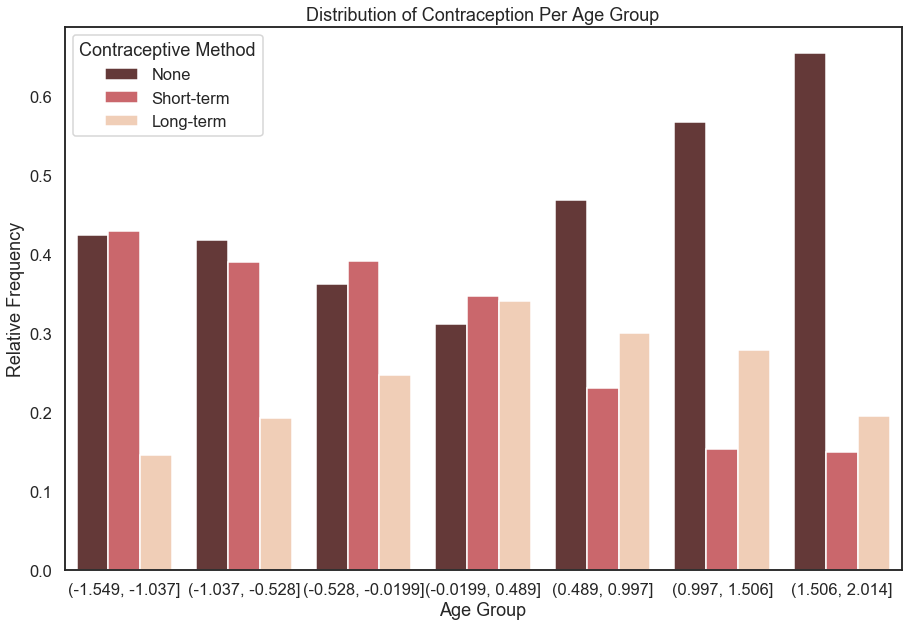

In [106]:
plt.figure(figsize=(15,10))
age_contra['contra_description'] = age_contra['contraceptive'].map({0:'None', 1:'Short-term', 2:'Long-term'})
ax = sns.barplot(x='age_bin',
            y='freq',
            hue='contra_description',
            data=age_contra)


ax.set(ylabel='Relative Frequency', xlabel='Age Group', title='Distribution of Contraception Per Age Group')
ax.legend(title='Contraceptive Method');

# Number of kids versus age.
Below, we plot the distribution of number of children within each wife age group. Recall that the age groups are standardized and the minimum wife age in our dataset is 20 years. Clearly, women in older age groups have a larger range and more children on average. The $R^2$ value between number of children and wife age is approximately 0.268. The relationship here does not seem to be linear as expected due in part to natural limitations of fertility.

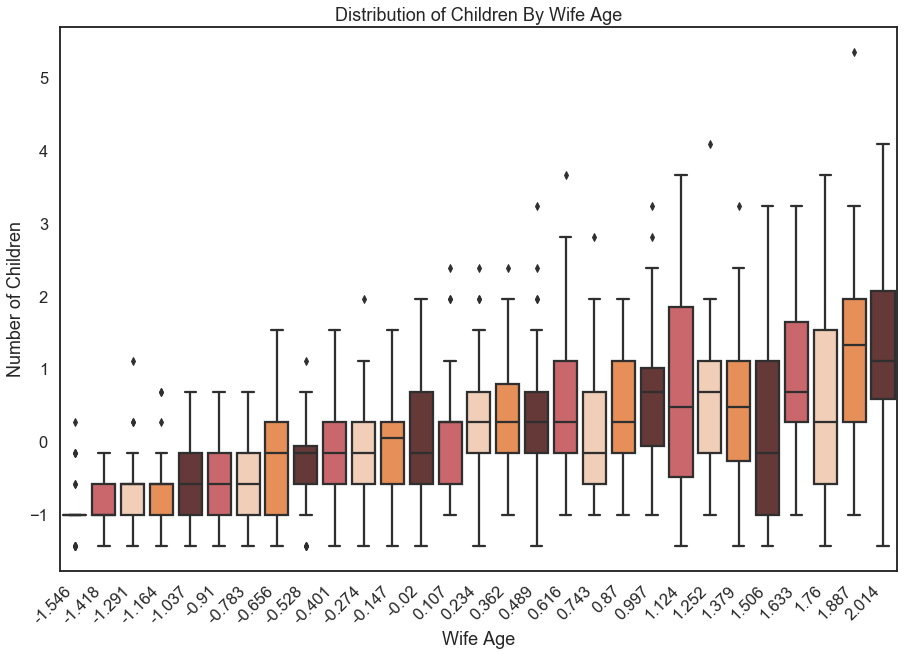

In [56]:
plt.figure(figsize=(15,10))
ax = sns.boxplot(x=round(contra_train['wife_age'], 3),
                 y='num_child',
                 data=contra_train,
                 palette=['#6B3231', '#DB565D', '#FACCAD', '#FF8A40'])

ax.set(ylabel='Number of Children',
       xlabel='Wife Age',
       title='Distribution of Children By Wife Age')

ax.set_xticklabels(
    ax.get_xticklabels(), 
    rotation=45, 
    horizontalalignment='right',
    fontweight='light');

In [71]:
r_sq = np.corrcoef(x=contra_train['wife_age'], y=contra_train['num_child'])[0,1]**2
print('The R^2 value between number of children and wife age is ' + str(r_sq) + '.')

The R^2 value between number of children and wife age is 0.2686244303731018.


# Kids per married year versus number of kids.
We are interested in the relationship between our engineered feature, KPMY, and the existing covariates of wife age and number of children. We see that the scatteplot between wife age and number of children shows patterns that can be explained by the feature's calculation. That is, there is a minimum estimated number of married years per age group, therefore KPMY has a linear offset for each level of number of children. There are also outliers where some women had many children very quickly with a high KPMY. The $R^2$ value between these two variables is 0.060 which provides evidence for a nonlinear relationship.

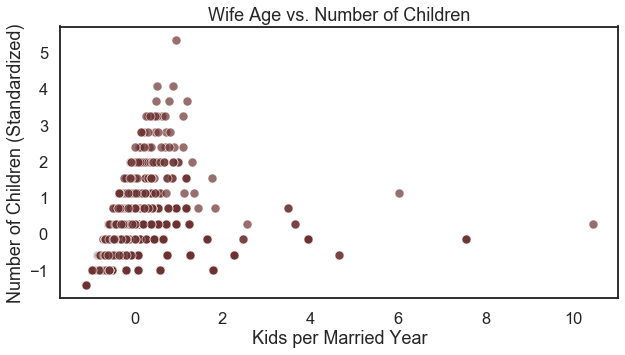

In [80]:
plt.figure(figsize=(10,5))
ax = sns.scatterplot(x='kids_per_year',
                     y='num_child',
                     data=contra_train,
                     alpha=0.7)

ax.set(ylabel='Number of Children (Standardized)',
       xlabel='Kids per Married Year',
       title='Wife Age vs. Number of Children');

In [69]:
r_sq = np.corrcoef(x=contra_train['kids_per_year'], y=contra_train['num_child'])[0,1]**2
print('The R^2 value between KPMY and number of children is ' + str(r_sq) + '.')

The R^2 value between KPMY and number of children is 0.059507960456157305.


# Kids per married year versus age.
The plot below reflects the relationship between KPMY and wife age. The relationship between these two variables exhibits qualities of an exponential decay curve shifted across multiple starting points. The $R^2$ value between these two variables is 0.157 which provides evidence for a nonlinear relationship.

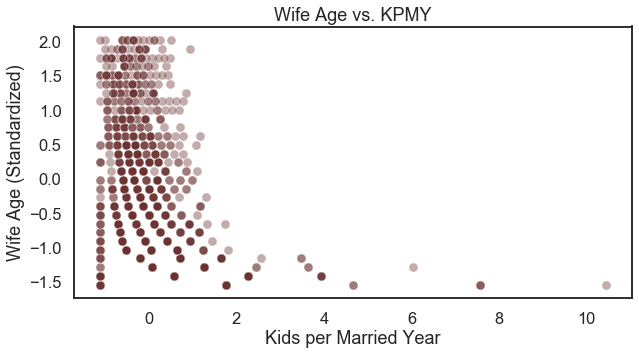

In [24]:
plt.figure(figsize=(10,5))
ax = sns.scatterplot(x='kids_per_year',
                     y='wife_age',
                     data=contra_train,
                     alpha=0.4)

ax.set(ylabel='Wife Age (Standardized)',
       xlabel='Kids per Married Year',
       title='Wife Age vs. KPMY');

In [70]:
r_sq = np.corrcoef(x=contra_train['kids_per_year'], y=contra_train['wife_age'])[0,1]**2
print('The R^2 value between KPMY and wife age is ' + str(r_sq) + '.')

The R^2 value between KPMY and wife age is 0.156683426744835.


# Kids per married year.

## Multiclass prediction.
Since we are using KPMY as a covariate in multiclass prediction, we check below if there are significant differences in KPMY values across the three classes: no contraception, short-term, and long-term. We will use a Kruskal-Wallis test to determine to test the hypothesis of whether or not the three groups share the same KPMY distribution. The resulting p-value of 4.219e-20 leads us to conclude that there are distributional differences of KPMY between the three classes.

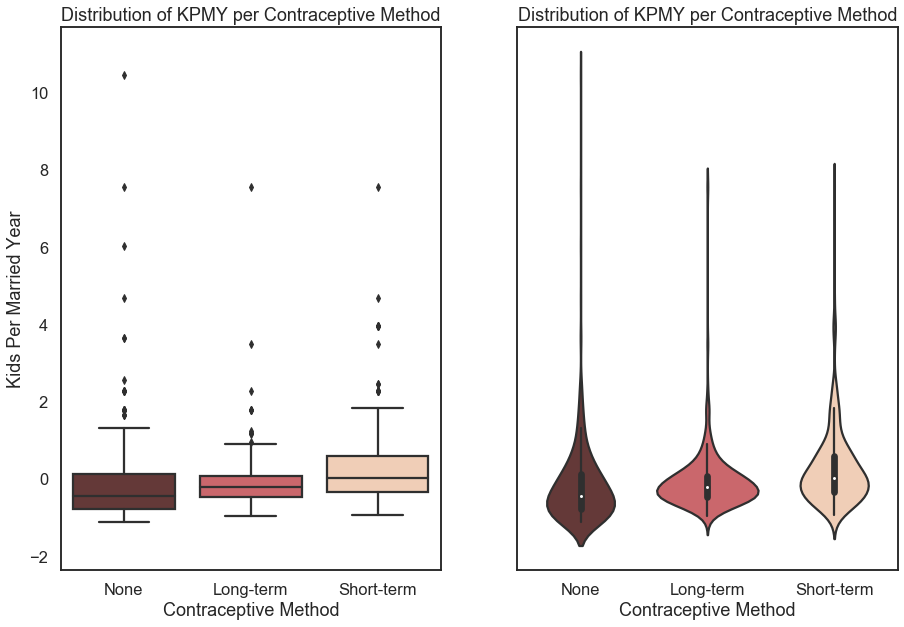

In [61]:
fig, ax = plt.subplots(1,2, sharey=True, figsize=(15,10))

sns.boxplot(x=contra_train['contraceptive'].map({0:'None', 1:'Short-term', 2:'Long-term'}),
            y='kids_per_year',
            data=contra_train,
            ax = ax[0])

ax[0].set(ylabel='Kids Per Married Year',
          xlabel='Contraceptive Method',
          title='Distribution of KPMY per Contraceptive Method');

sns.violinplot(x=contra_train['contraceptive'].map({0:'None', 1:'Short-term', 2:'Long-term'}),
               y='kids_per_year',
               data=contra_train,
               ax = ax[1])

ax[1].set(ylabel='',
       xlabel='Contraceptive Method',
       title='Distribution of KPMY per Contraceptive Method')


plt.show()

In [108]:
from scipy import stats
stats.kruskal(contra_train['kids_per_year'][contra_train['contraceptive'] == 0], 
              contra_train['kids_per_year'][contra_train['contraceptive'] == 1],
              contra_train['kids_per_year'][contra_train['contraceptive'] == 2])

KruskalResult(statistic=89.22432195736684, pvalue=4.218758460959621e-20)

## Binary prediction.
Since we are also interested in the binary prediction between women who use and do not use contraception in our dataset, we will test the hypothesis of whether KPMY is distributed the same between these binary groups. We will opt for a Mann-Whitney U test to circumvent distributional assumptions. We conclude that there are distributional differences for KPMY between the no contraception and the contraception groups. (p-value=2.363e-17).

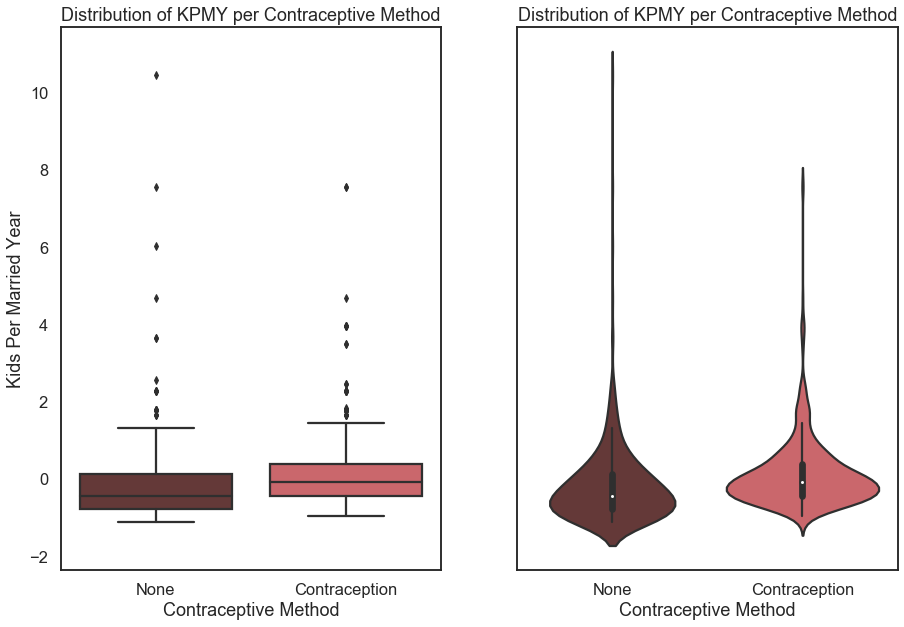

In [60]:
fig, ax = plt.subplots(1,2, sharey=True, figsize=(15,10))

sns.boxplot(x=contra_train['contraceptive'].map({0:'None', 1:'Contraception', 2:'Contraception'}),
            y='kids_per_year',
            data=contra_train,
            ax = ax[0])

ax[0].set(ylabel='Kids Per Married Year',
          xlabel='Contraceptive Method',
          title='Distribution of KPMY per Contraceptive Method');

sns.violinplot(x=contra_train['contraceptive'].map({0:'None', 1:'Contraception', 2:'Contraception'}),
               y='kids_per_year',
               data=contra_train,
               ax = ax[1])

ax[1].set(ylabel='',
       xlabel='Contraceptive Method',
       title='Distribution of KPMY per Contraceptive Method')


plt.show()

In [110]:
from scipy import stats
stats.mannwhitneyu(x=contra_train['kids_per_year'][contra_train['contraceptive'] == 0],
                   y=contra_train['kids_per_year'][contra_train['contraceptive'].isin([1,2])])

MannwhitneyuResult(statistic=95722.0, pvalue=2.3633774084244153e-17)

# Confusion Matrices.

**PLEASE READ**: I am going to use arbitrary predictions. Please feed in the correct ones whenever.

## Multiclass confusion matrix.

In [146]:
from sklearn.linear_model import LogisticRegression
multinomial_logit = LogisticRegression(multi_class='multinomial', solver='newton-cg')
multinomial_logit.fit(X=contra_train[['education_gap', 'kids_per_year']],
                      y=contra_train['contraceptive'])

train_accuracy = multinomial_logit.score(X=contra_train[['education_gap', 'kids_per_year']],
                                         y=contra_train['contraceptive'])


train_accuracy

0.46117424242424243

In [147]:
from sklearn.metrics import confusion_matrix
predictions = multinomial_logit.predict(X=contra_train[['education_gap', 'kids_per_year']])
truth = contra_train['contraceptive']
multi_confusion = pd.DataFrame(confusion_matrix(predictions, truth))
multi_confusion

,0,1,2
0,380,240,203
1,64,94,34
2,14,14,13


In [148]:
multi_confusion / contra_train.shape[0]

,0,1,2
0,0.359848,0.227273,0.192235
1,0.060606,0.089015,0.032197
2,0.013258,0.013258,0.012311


**To be changed to whichever situation:**

*Based on the frequencies above, we made the most amount of errors predicting a woman who did not use contraception into other groups. 22.7% of our predictions misclassified women who did not use contraceptives as women who used short-term contraception.*

*Our predictor did not do well in separating long-term cases. The long-term contraception group was predicted almost equally to be any of the three classes.*

## Binary confusion matrix.

In [155]:
from sklearn.linear_model import LogisticRegression
binomial_logit = LogisticRegression(solver='lbfgs')
binomial_logit.fit(X=contra_train[['education_gap', 'kids_per_year']],
                   y=contra_train['contraceptive_use'])

train_accuracy = binomial_logit.score(X=contra_train[['education_gap', 'kids_per_year']],
                                      y=contra_train['contraceptive_use'])


train_accuracy

0.6363636363636364

In [156]:
from sklearn.metrics import confusion_matrix
predictions = binomial_logit.predict(X=contra_train[['education_gap', 'kids_per_year']])
truth = contra_train['contraceptive_use']
binary_confusion = pd.DataFrame(confusion_matrix(predictions, truth))
binary_confusion

,0,1
0,171,97
1,287,501


In [145]:
binary_confusion / contra_train.shape[0]

,0,1
0,0.161932,0.091856
1,0.271780,0.474432


**To be changed to fit the situation:**

*Our binary predictor was able to detect 63.63% percent of the dataset correctly. Most of the errors made were predicting a woman who did use a contraceptive as part of the 'None' group. This was done 27.18% of the time.*

# Precision/Recall.

Finally, we want to use apply our predictive models to our test set which was not used anywhere in our predictive modeling process.

## Multiclass prediction.

**To be changed to fit the situation**:

*For the multiclass setting, we examined the medians and standard deviations of the predicted probabilities per each subject. This measure explains how definitive our model was at predicting their classes.*

*For example, the row `[0.713063, 0.195492, 0.091445]` has a median of 0.195 and standard deviation of 27.185%. Based on the boxplot of medians below, 0.195 is quite small. Based on the boxplot of standard deviations below, a definitive row of predicted probabilities like this has a high standard deviation in comparison to the rest of the predictions. These two pieces of evidence show that our model is predicting probabilities that are quite uniform.*

In [250]:
probs = multinomial_logit.predict_proba(contra_test[['education_gap', 'kids_per_year']])
probs_df = pd.DataFrame(probs, columns={0,1,2})
probs_df.head()

,0,1,2
0,0.353631,0.362886,0.283483
1,0.432966,0.275803,0.291231
2,0.361714,0.353487,0.284799
3,0.492023,0.335032,0.172945
4,0.389317,0.322302,0.288381


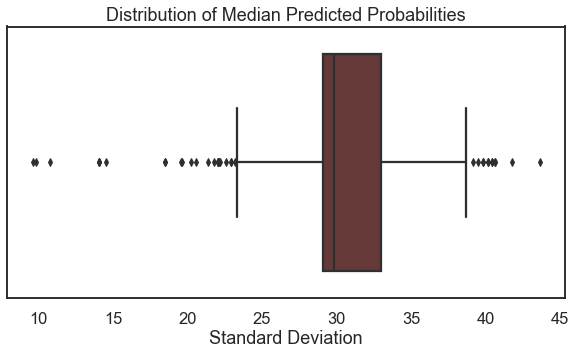

In [257]:
plt.figure(figsize=(10,5))
ax = sns.boxplot((probs_df*100).apply(np.median, axis=1))

ax.set(ylabel='',
       xlabel='Standard Deviation',
       title='Distribution of Median Predicted Probabilities');

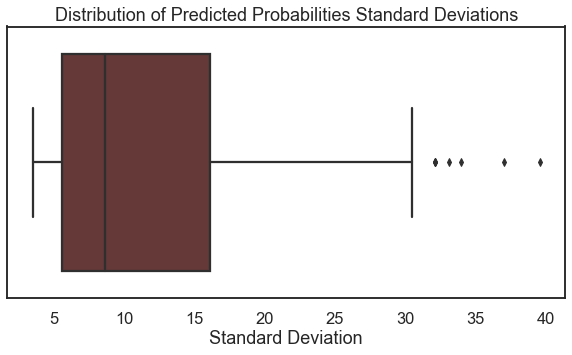

In [246]:
plt.figure(figsize=(10,5))
ax = sns.boxplot((probs_df*100).apply(np.std, axis=1))

ax.set(ylabel='',
       xlabel='Standard Deviation',
       title='Distribution of Predicted Probabilities Standard Deviations');

## Binary prediction.

**To be changed to fit the situation:**

*We calculated the precision and recall for our predictions on our test set. We had a 66.54% precision rate and a 79.72% recall rate. We also plotted the precision-recall curve for our logistic regression model and a "no skill" predictor which would predict the classification probabilities to be the sample average.*

In [222]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

# CALCULATE PRECISION AND RECALL VALUES
precision = precision_score(contra_test['contraceptive_use'],
                            binomial_logit.predict(X=contra_test[['education_gap', 'kids_per_year']]))

recall = recall_score(contra_test['contraceptive_use'],
                      binomial_logit.predict(X=contra_test[['education_gap', 'kids_per_year']]))

print('Precision: %f' % precision)
print('Recall: %f' % recall)

Precision: 0.665385
Recall: 0.797235


In [213]:
from sklearn.metrics import precision_recall_curve

# PREDICTED PROBABILITIES
# JUST EDIT THE "PREDICT" CODE
lr_probs = binomial_logit.predict_proba(contra_test[['education_gap', 'kids_per_year']])
lr_probs = lr_probs[:, 1]

# NOTICE THIS IS ON THE TEST VALUES
lr_precision, lr_recall, _ = precision_recall_curve(contra_test['contraceptive_use'], lr_probs)
no_skill = len(contra_test['contraceptive_use'][contra_test['contraceptive_use']==1]) / len(contra_test['contraceptive_use'])

# CREATE A PLOTTABLE DF
our_df = pd.DataFrame({'recall':lr_recall, 'logistic':lr_precision, 'no_skill':[no_skill]*len(lr_precision)})
our_df = pd.melt(our_df, id_vars='recall')

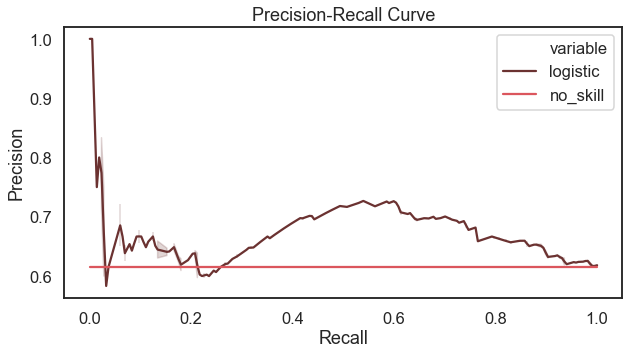

In [220]:
plt.figure(figsize=(10,5))
ax = sns.lineplot(x='recall',
                  y='value',
                  hue='variable',
                  data=our_df)

ax.set(ylabel='Precision',
       xlabel='Recall',
       title='Precision-Recall Curve');